## Tutorial- Movie Recommender System using Text Mining

In this modern era, all the companies have started using recommender systems more and more to enhance their customer experience. 
There are two basic types of recommender systems algorithm namely Collabrative filtering based and content-based filtering (also known as pensonality-based approach). Both these approaches are used heavily. 
I will be discussing the former approach that is the content-based approach. Let me discuss few examples of this approach first-


• Pandora uses the properties of songs and artist (around 400 and so variables) to create different types of stations for users like pop artist and pop songs are listed under the same station.


• Content based systems are also used by e-commerce companies to suggest items to the user based on filters set by the user.

Now, that we have some rough sketch on what a *content based system* does. Lets talk about the algorithm on a high level and understand how does this work. So basically, we have to create different profiles for the pool of items among which we need to make the recommendations and we create a profile based on user's choice or previous items they have rated highly. Once this is done, we compare these in n-dimensional space and compute the similarity between them and recommend those items to the user which are the most similar to the user's profile.

#### Motivation
Motivation behind this movie recommender system is say a user searches for a movie that he likes then it is upto which movies should we recommend to him that he can look at after that movie. This is the similar approach that is used by big companies like Netflix, IMDB for recommending movies based on user choice. A similar approach is used by amazon to show suggested items in their catalog once a user clicks and opens a particular item. This helps companies to show users only those items that are relevant to them.

<img src='http://blog.allmyfaves.com/wp-content/uploads/2012/07/foundd-what-movie-should-I-watch-tonight.jpg'>

#### Datasets

The data used for this tutorial has been consumed from Kaggle
Dataset Source :-  https://www.kaggle.com/tmdb/tmdb-movie-metadata/data

I have uploaded the datasets at the following google drive as well:-
https://goo.gl/bms7ES

#### Methodology

So my methodology for this tutorial is based on the same algorithm.
1. I have used a movie dataset where user profile will be created by using user's selection.
2. We compare these user's selection with all the movies in the dataset.
3. We compare these profiles(vectors) using cosine similarities. (To make these profiles we will have to process our dataset into data that will be required for making vectors)

To create the user profiles and the item profiles I will be using keywords from the movie's overview (which are calculated using Tf-Idf) and similarly, among the tags for each I have calculated the top tags that represent that movie. I will also be using features like movie ratings, actors, director etc to create profiles.

###### Let's get started

First step is importing required libraries
1. We have imported pandas for basic dataframe manipulations
2. We have imported numpy for array manipulation
3. We have imported matplotlib for initial visualization
4. We have imported csv to import csv files 

In [1]:
import pandas as pd
import numpy as np
#Library used for initial visualization
import matplotlib.pyplot as plt 
#Library used for initial visualization
import csv 
import ast
import re
%matplotlib inline

We will now load and merge the two datasets that we have one dataset is credits dataset that contains information like cast, crew information. Second dataset is movies dataset which contains information genres, language, overview, vote_average.

In [2]:
credits_csv=pd.read_csv('E:\\Film Recommendation Engine\\tmdb_5000_credits.csv')#change file path
movies_csv=pd.read_csv('E:\\Film Recommendation Engine\\tmdb_5000_movies.csv')#change file path
data=pd.merge(credits_csv, movies_csv, left_on='movie_id', right_on='id')
#To drop columns that have been repeated
data=data.drop(['id','title_x'],axis=1) 
#Renaming particular columns
data.rename(columns={'title_y':'title'}, inplace=True) 
#Descriptive Statistics on the numberical data
data.describe() 

,movie_id,budget,popularity,revenue,runtime,vote_average,vote_count
count,4803.000000,4.803000e+03,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,57165.484281,2.904504e+07,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,88694.614033,4.072239e+07,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,5.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,9014.500000,7.900000e+05,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,14629.000000,1.500000e+07,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,58610.500000,4.000000e+07,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,459488.000000,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


Checking outliers in numberical variables

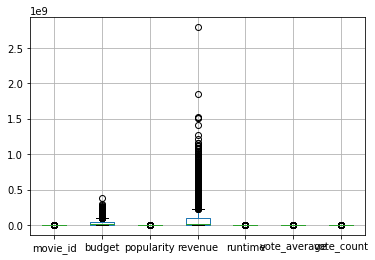

In [3]:
data.boxplot()

Checking for null values

In [4]:
data.isnull().sum()

movie_id                   0
cast                       0
crew                       0
budget                     0
genres                     0
homepage                3091
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

We check the datatype for each of the column in the dataset.

In [5]:
data.dtypes

movie_id                  int64
cast                     object
crew                     object
budget                    int64
genres                   object
homepage                 object
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object

We have to process the types for columns that contain JSON type data(lists, dictionaries) because while reading the files they are just loaded as strings (represented as object types). We have to convert them to their appropriate types.

In [6]:
#This cell should be run only once because the values once converted are no longer string type 
data["genres"]=data["genres"].apply(ast.literal_eval)
data["spoken_languages"]=data["spoken_languages"].apply(ast.literal_eval)
data["cast"]=data["cast"].apply(ast.literal_eval)
data["crew"]=data["crew"].apply(ast.literal_eval)
data["keywords"]=data["keywords"].apply(ast.literal_eval)


Following libraries are required for text manipulation and text mining of the overview and keywords in the movie.
Stemmer is used to extract only the stem of a word.

After looking at the whole dataset I have decided to use only the following columns:-

1. Overview (Description of the movie can suggest the type of movie and give us the keywords in a movie for example say we have Superman, the movie is based on a comic so most likely comic will be a keyword in the overview)

2. Genres (Genre is very indicative of the taste of the user and thus must be used)

3. Keywords (These are keywords pre existing in the data that can be said to be tags representing a movie)

4. Actors (A person watches a movie if he likes a particular actor and that is why we need to include main actors but not all actors as supporing actors are not much of interest)

5. Director (People often go for watching a movie based on the director as a director who has a good reputation in the industry is more sort after)

6. Language (Language which the movie is indicate of a person's native language)

7. voting_average (The score of the movie and how much it has been rated overall)

In [7]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

This following functions takes in a document and calculates the term-frequencies and returns the dictionary with frequencies for each word in the document.

Though the TF formula used here is different from what we studied in the class which was just calculating the total count of each word in each document.

Here rather we have documents(overviews) which are very different in lengths so TF alone will not be indicative enough. Thus we normalize them by calculating (1+log(word_count)) and then normalizing these across all the documents by dividing this by vector length.

Reference:- 
https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/

The formula used here is :- (1+np.log10(word_count))/vector_length)

In [8]:
from collections import Counter
def tf(overview):
    vector_length=0
    overview_words=re.sub("[^\w'-]"," ", str(overview).lower()).split()
    stemmed_words=list()
    for word in overview_words:
        stemmed_words.append(ps.stem(word))
    overview_words=Counter(stemmed_words) 
    
    words_dicts=dict()
    for word,count in overview_words.items():
        vector_length+=((1+np.log10(count))**(2))
    vector_length=vector_length**(0.5)
    for word,count in overview_words.items():
        words_dicts.update({ps.stem(word):((1+np.log10(count))/vector_length)})
    return words_dicts


The following function is used to calculate idf from a set of documents that is passed using a list and we calculate idf for each term.

The motivation behind idf(inverse document frequency) is that all the words in a document are not necessarily useful in modelling the topics for that document.

In the function we use a loop to iteratre over each document and split it into words and stem the words that is extracting only the root of that word because words can be in different forms. Then we use idf formula to calculate idf for each unique word in the set of documents.

Formula used for calculating the IDF is :- np.log10(number of documents/number of documents containg that word)



In [9]:
#pass a list of documents
def idf(idf_data): 
    idf_dict=dict()
    for docs in idf_data:
        doc_words=re.sub("[^\w'-]"," ", str(docs).lower()).split()
        stemmed_words=list()
        for word in doc_words:
            stemmed_words.append(ps.stem(word))
        
        doc_words=list(set(stemmed_words))
        for word in doc_words:
            if ps.stem(word.lower()) not in idf_dict.keys():
                idf_dict.setdefault(ps.stem(word.lower()), 1)
            else:
                idf_dict[ps.stem(word.lower())]+=1
    for key,value in idf_dict.items():
        idf_dict[key]=np.log10(len(idf_data)/value)
    return idf_dict
       


#### Now we start processing our data based on our requirements


We are processing following columns that we discussed to be using initially.

Now we have to process our data to extract actors from the dataset we will be using the main actors in a movie to do so we will only be using the main three actors of the movie which are represented in the cast of the movie as actor with order 0,1 and 2.
We create a dataframe that has the top three actors in each movie.

In [10]:
actors=list()

for i in range(0,len(data.index)):
    actors.append([d['name'].strip() for d in data['cast'][i] if d['order'] == 0 or d['order'] == 1 or d['order'] == 2])
    
labels=['actor1','actor2','actor3','actor4','actor5']
actors_df=pd.DataFrame.from_records(actors,columns=labels,exclude=['actor4','actor5'])

We apply TF-IDF on overview and make a new dataframe with only top 5 important words in each document.

In [11]:
tfidf_column=[]
idf_dict=idf(data["overview"])
for overview in data["overview"]:        
    tfidf_dict=tf(overview)
    for key,value in tfidf_dict.items():
        tfidf_dict[key]=value*idf_dict[key]
    tfidf_dict=sorted(tfidf_dict, key=tfidf_dict.get, reverse=True)[:5]
    tfidf_column.append(tfidf_dict)
importantwords_df=pd.DataFrame(tfidf_column,columns=["Key1","Key2","Key3","Key4","Key5"])
importantwords_df

,Key1,Key2,Key3,Key4,Key5
0,parapleg,pandora,22nd,moon,dispatch
1,barbossa,swann,turner,edg,elizabeth
2,peel,layer,spectr,cryptic,deceit
3,dent',attorney',batman,selina,bane
4,barsoom,war-weari,carter,rediscov,embroil
5,spider-man,sandman,shape-shift,all-new,brock
6,wanted-and,charming-bandit,rapunzel,tower-bound,flynn'
7,jumpstart,mightiest,peacekeep,ultron,enact
8,'properti,half-blood,voldemort',prince',sixth
9,god-lik,uncheck,metropoli,savior,superman


Now, for looking at the genres of the movie we are going to make a dataframe that gets all the genres from the movies and creates a dummy variable that gives 0 or 1 respective to if that movie corresponds to that genre or not.

In [12]:
genre_list=[]
for genre in data["genres"]:
    for d in genre:
        if d['name'] not in genre_list:
            genre_list.append(d['name'])

all_movies=[]
for genre in data["genres"]:
    movie_genres=dict()
    for gen in genre_list:
        movie_genres.setdefault(gen, 0)
    for d in genre:
        movie_genres[d['name']]=1
    all_movies.append(movie_genres)
genres_df=pd.DataFrame(all_movies)


We extract the Director from the list of crew members and create a new column that has the director of each movie.

In [13]:
directors_list=list()
for crew in data["crew"]:
    director_flag=0
    for d in crew:
        if d['job']=="Director":
            directors_list.append({"Director":d['name']})
            director_flag=1
            break
    if director_flag==0:
        directors_list.append({"Director":''})

directors_df=pd.DataFrame(directors_list)


Now for the list of keywords that exists in our movie dataset already are basically the search tags that represent the movie and the we extract the keywords that have the highest tf-idf among the list of words as those keywords are the most unique tags for each movie.

In [14]:
keywords_column=list()
for movie_keywords in data["keywords"]:
    keywords=''
    for d in movie_keywords:
        keywords=keywords+ps.stem(d['name'])+' '
    keywords_column.append(keywords.strip())
    
keywords_df=pd.DataFrame(keywords_column)

tfidf_column2=[]
idf_dict2=idf(keywords_df[0])
for docs in keywords_df[0]:        
    tfidf_dict=tf(docs)
    for key,value in tfidf_dict.items():
        tfidf_dict[key]=value*idf_dict2[key]
    tfidf_dict=sorted(tfidf_dict, key=tfidf_dict.get, reverse=True)[:5]
    tfidf_column2.append(tfidf_dict)
keywords_5df=pd.DataFrame(tfidf_column2,columns=["Keyword1","Keyword2","Keyword3","Keyword4","Keyword5"])


We concatenate all the columns that we have processed and create a new result dataset that we will use to make the user and item profiles.

In [15]:
#Concatenating
result=pd.concat([data,actors_df,directors_df,genres_df,importantwords_df,keywords_5df],axis=1)
#Normalizing vote_average to change the range to 0 to 1
result["vote_average"]=result["vote_average"]*0.1

### User selection

This is the user selection that we need use to create the user profile.

### You can make the user selection multiple times but you need to run the next cell too with it.

In [16]:
import ipywidgets as widgets

user_movie=widgets.Dropdown(
    options=sorted(list(result["title"])),
    description='Please choose a movie:',
    disabled=False,
)
user_movie

Above is a dropdown when you run the notebook you can choose the movie using this drop down. 

I have run the notebook and selecting the movie as **"2 Fast 2 Furious"**

### Steps Followed:-

1. We create a user profile and first the row from the dataset that corresponds to users selected movie.
2. We use original_language, actors, director, keys(from overview) and keywords and code 1 or 0 for each movie.
3. For the user profile each of the above is 1.
4. Then we drop irrelevant columns.
5. We subset the data to remove the user's selection from the original dataset.
6. We compute the cosine similarities between to dataset(one dataset represents user profile and other represents item profiles)
7. We sort the cosine similarities by lowest to highest.
8. We pick the last 5.
9. Recommend the 5 movies we picked

In [19]:
import sklearn.metrics.pairwise
print("Movie selected is "+user_movie.value)
user_profile=result.loc[result['title']==str(user_movie.value)]

user_profile=user_profile.drop(['cast','crew','popularity', 'budget', 'genres', 'homepage', 'keywords','original_title','overview', 'production_companies','production_countries','release_date', 'revenue', 'runtime', 'spoken_languages', 'status','tagline','vote_count'],axis=1)
actor1=user_profile['actor1'].tolist()
actor2=user_profile['actor2'].tolist()
actor3=user_profile['actor3'].tolist()
original_language=user_profile['original_language'].tolist()
Director=user_profile['Director'].tolist()
Key1=user_profile['Key1'].tolist()
Key2=user_profile['Key2'].tolist()
Key3=user_profile['Key3'].tolist()
Key4=user_profile['Key4'].tolist()
Key5=user_profile['Key5'].tolist()
Keyword1=user_profile['Keyword1'].tolist()
Keyword2=user_profile['Keyword2'].tolist()
Keyword3=user_profile['Keyword3'].tolist()
Keyword4=user_profile['Keyword4'].tolist()
Keyword5=user_profile['Keyword5'].tolist()


actor_list=[actor1[0],actor2[0],actor3[0]]
key_list=[Key1[0],Key2[0],Key3[0],Key4[0],Key5[0]]
keyword_list=[Keyword1[0],Keyword2[0],Keyword3[0],Keyword4[0],Keyword5[0]]


user_profile['actor1'] = np.where(user_profile.actor1.isin(actor1),1,0)
user_profile['actor2'] = np.where(user_profile.actor2.isin(actor2),1,0)
user_profile['actor3'] = np.where(user_profile.actor3.isin(actor3),1,0)
user_profile['original_language'] = np.where(user_profile.original_language.isin(original_language),1,0)
user_profile['Director'] = np.where(user_profile.Director.isin(Director),1,0)
user_profile['Key1'] = np.where(user_profile.Key1.isin(Key1),1,0)
user_profile['Key2'] = np.where(user_profile.Key2.isin(Key2),1,0)
user_profile['Key3'] = np.where(user_profile.Key3.isin(Key3),1,0)
user_profile['Key4'] = np.where(user_profile.Key4.isin(Key4),1,0)
user_profile['Key5'] = np.where(user_profile.Key5.isin(Key5),1,0)
user_profile['Keyword1'] = np.where(user_profile.Keyword1.isin(Keyword1),1,0)
user_profile['Keyword2'] = np.where(user_profile.Keyword2.isin(Keyword2),1,0)
user_profile['Keyword3'] = np.where(user_profile.Keyword3.isin(Keyword3),1,0)
user_profile['Keyword4'] = np.where(user_profile.Keyword4.isin(Keyword4),1,0)
user_profile['Keyword5'] = np.where(user_profile.Keyword5.isin(Keyword5),1,0)

item_profiles=result.drop(['cast','crew','popularity', 'budget', 'genres', 'homepage', 'keywords','original_title','overview', 'production_companies','production_countries','release_date', 'revenue', 'runtime', 'spoken_languages', 'status','tagline','vote_count'],axis=1)
item_profiles=item_profiles.loc[~(data['original_title']==str(user_movie.value))]
item_profiles['actor1'] = np.where(item_profiles.actor1.isin(actor_list),1,0)
item_profiles['actor2'] = np.where(item_profiles.actor2.isin(actor_list),1,0)
item_profiles['actor3'] = np.where(item_profiles.actor3.isin(actor_list),1,0)
item_profiles['original_language'] = np.where(item_profiles.original_language.isin(original_language),1,0)
item_profiles['Director'] = np.where(item_profiles.Director.isin(Director),1,0)
item_profiles['Key1'] = np.where(item_profiles.Key1.isin(key_list),1,0)
item_profiles['Key2'] = np.where(item_profiles.Key2.isin(key_list),1,0)
item_profiles['Key3'] = np.where(item_profiles.Key3.isin(key_list),1,0)
item_profiles['Key4'] = np.where(item_profiles.Key4.isin(key_list),1,0)
item_profiles['Key5'] = np.where(item_profiles.Key5.isin(key_list),1,0)

item_profiles['Keyword1'] = np.where(item_profiles.Keyword1.isin(keyword_list),1,0)
item_profiles['Keyword2'] = np.where(item_profiles.Keyword2.isin(keyword_list),1,0)
item_profiles['Keyword3'] = np.where(item_profiles.Keyword3.isin(keyword_list),1,0)
item_profiles['Keyword4'] = np.where(item_profiles.Keyword4.isin(keyword_list),1,0)
item_profiles['Keyword5'] = np.where(item_profiles.Keyword5.isin(keyword_list),1,0)


item_profiles
x=user_profile.drop(['title','movie_id'],axis=1)
y=item_profiles.drop(['title','movie_id'],axis=1)


arr = sklearn.metrics.pairwise.cosine_similarity(x,y, dense_output=True)
arr_index=arr.argsort()
arr_index=arr_index.ravel()
final_df=pd.DataFrame(arr_index).tail(5)
final_df
item_profiles=item_profiles.iloc[final_df[0]]
item_profiles=item_profiles.iloc[::-1]
item_profiles

Movie selected is 2 Fast 2 Furious


,movie_id,original_language,title,vote_average,actor1,actor2,actor3,Director,Action,Adventure,...,Key1,Key2,Key3,Key4,Key5,Keyword1,Keyword2,Keyword3,Keyword4,Keyword5
99,9799,1,The Fast and the Furious,0.66,1,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,1
204,51497,1,Fast Five,0.71,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
405,9615,1,The Fast and the Furious: Tokyo Drift,0.61,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
629,136797,1,Need for Speed,0.61,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
1792,134374,1,Pain & Gain,0.61,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
print("Recommended Movies for "+ user_movie.value + ": \n\n"+'\n'.join(list(item_profiles["title"])))

Recommended Movies for 2 Fast 2 Furious: 

The Fast and the Furious
Fast Five
The Fast and the Furious: Tokyo Drift
Need for Speed
Pain & Gain


Play Around and try other movies choose different movies from the dropdown.

## References

1. Content Based Recommendations | Stanford University. (2018). YouTube. Retrieved 31 March 2018, from https://www.youtube.com/watch?v=2uxXPzm-7FY

2. Engines, B., Engines, B., & Das, S. (2018). Beginners Guide to learn about Content Based Recommender Engine. Analytics Vidhya. Retrieved 31 March 2018, from https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/

3. Lecture 16.2 — Recommender Systems | Content Based Recommendations — [ Andrew Ng ]. (2018). YouTube. Retrieved 31 March 2018, from https://www.youtube.com/watch?v=9siFuMMHNIA

4. Overview of Recommender Systems | Stanford University. (2018). YouTube. Retrieved 31 March 2018, from https://www.youtube.com/watch?v=1JRrCEgiyHM&t=627s

5. Recommender system. (2018). En.wikipedia.org. Retrieved 31 March 2018, from https://en.wikipedia.org/wiki/Recommender_system

## Further reads

Further resources for better understanding of recommender systems:-

A good read to know more about the other most widely used recommendation algorithm Collaborative Filtering http://www.cs.umd.edu/~samir/498/Amazon-Recommendations.pdf .This paper talks about amazon's use of item-to-item collaborative filtering.

If you want to deep dive into the topic and understand different algorithms more thoroughly. I recommend this course https://www.coursera.org/specializations/recommender-systems.

Another great tutorial if you want to look at another example of content based recommender systems.
https://www.themarketingtechnologist.co/a-recommendation-system-for-blogs-content-based-similarity-part-2/

A good read on hybrid recommender systems
https://www.hindawi.com/journals/mpe/2015/145636/


## Conclusion

Recommender systems are very widely used in the industry right now and is one of the must have skills on your resume. For the other most widely used recommender systems and you can go through the some of the readings I suggested above and look at the problems related to recommender systems like cold start problem(The algorithm we have discussed in this tutorial can address this problem). And read how both these algorithms are used in a hybrid algorithm to solve some of these problems.
Apart from this content based recommender system does not have any particular fixed metric for evaluation, but in the case of Collaborative filtering we can evaluate our model using users previous ratings and dividing our data into training and test sets. 